In [144]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

#Function

In [145]:
def plot_loss(history):
  history_dataframe = pd.DataFrame(history.history)

  min_loss_index = history_dataframe[history_dataframe['loss']==min(history_dataframe['loss'])].index.values
  min_loss = history_dataframe.loc[min_loss_index]['loss']
  min_val_loss_index = history_dataframe[history_dataframe['val_loss']==min(history_dataframe['val_loss'])].index.values
  min_val_loss = history_dataframe.loc[min_val_loss_index]['val_loss']

  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.plot(min_loss_index, min_loss, 'o', c='k', ms=4, label='min loss')
  plt.plot(min_val_loss_index, min_val_loss, 'o', c='k', ms=4, label='min val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.grid(True)
  plt.show()

  print("Minimun Loss :", min_loss)
  print("---------------------------------------")
  print("Minimun Validation Loss :", min_val_loss)

In [146]:
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	return df

In [147]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [148]:
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)

#Datetime Parser

In [149]:
dataset = pd.read_csv('/content/drive/My Drive/Colab_Test/Dataset/6. Deep Learning/birth.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

dataset.head()

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: Births, dtype: int64

#Plot Dataset

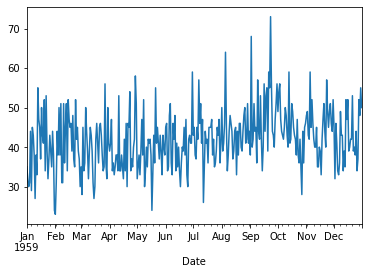

In [150]:
dataset.plot()
plt.show()

### **Dari grafik diatas, terdapat Trend dan Seasonality pada data ini yang mana dapat dilihat dari grafik yang stabil dan naik.**

#Processing Time-Series Data

In [151]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [152]:
lag = 1

raw_values = dataset.values
diff_values = difference(raw_values, 1)

diff_values

0      -3
1      -2
2       1
3      13
4     -15
       ..
359     3
360    15
361    -4
362     7
363    -5
Length: 364, dtype: int64

In [153]:
supervised = timeseries_to_supervised(diff_values, lag)
supervised

,0,0
0,NaN,-3
1,-3.0,-2
2,-2.0,1
3,1.0,13
4,13.0,-15
...,...,...
359,-10.0,3
360,3.0,15
361,15.0,-4
362,-4.0,7


In [154]:
supervised_values = supervised.values[lag:,:]
supervised_values

array([[ -3.,  -2.],
       [ -2.,   1.],
       [  1.,  13.],
       [ 13., -15.],
       [-15.,  16.],
       [ 16.,  -2.],
       [ -2.,  -5.],
       [ -5., -11.],
       [-11.,  11.],
       [ 11.,  -5.],
       [ -5.,  22.],
       [ 22.,  -8.],
       [ -8.,  -2.],
       [ -2.,  -8.],
       [ -8.,  13.],
       [ 13.,  -7.],
       [ -7.,  -2.],
       [ -2.,  11.],
       [ 11., -18.],
       [-18.,  19.],
       [ 19., -14.],
       [-14.,  -7.],
       [ -7.,   5.],
       [  5.,   6.],
       [  6.,  -4.],
       [ -4.,  -4.],
       [ -4.,   9.],
       [  9.,  -6.],
       [ -6., -14.],
       [-14.,  -1.],
       [ -1.,   8.],
       [  8.,  13.],
       [ 13.,  -6.],
       [ -6.,  12.],
       [ 12., -12.],
       [-12.,  13.],
       [ 13., -20.],
       [-20.,   0.],
       [  0.,  20.],
       [ 20., -15.],
       [-15.,   9.],
       [  9.,   6.],
       [  6., -17.],
       [-17.,  18.],
       [ 18.,  -5.],
       [ -5.,  -2.],
       [ -2.,   1.],
       [  1.,

In [155]:
split_percentage = 0.75

train_size = int(split_percentage * len(supervised_values))

train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

In [156]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

#Deep Learning

In [157]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf, random
from tensorflow.keras.layers import LSTM

##Baseline Model

In [158]:
neurons = 1
epoch = 1000
batch_size = 32
reset_random_seeds()

feature_train, label_train = train_scaled[:, 0:-1], train_scaled[:, -1]
feature_test, label_test = test_scaled[:, 0:-1], test_scaled[:, -1]

base_model = Sequential()
base_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
base_model.add(Dense(1))
base_model.compile(loss='mean_squared_error', optimizer='adam')

In [159]:
reset_random_seeds()
history_basemodel = base_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 1s 70ms/step - loss: 0.1103 - val_loss: 0.0696
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1097 - val_loss: 0.0692
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1091 - val_loss: 0.0688
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1086 - val_loss: 0.0684
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1081 - val_loss: 0.0681
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1076 - val_loss: 0.0677
Epoch 7/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1070 - val_loss: 0.0674
Epoch 8/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1066 - val_loss: 0.0672
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1061 - val_loss: 0.0669
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1057 - val_loss: 0.0666
Epoch 11/1000
9/9 

In [160]:
loss = base_model.evaluate(feature_test, label_test, verbose=2)
print("Test Loss -> ",loss)

3/3 - 0s - loss: 0.0568
Test Loss ->  0.05679210647940636


In [161]:
history_dataframe = pd.DataFrame(history_basemodel.history)
history_dataframe['epoch'] = history_basemodel.epoch
history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
214,0.087213,0.056730,214
216,0.087222,0.056730,216
215,0.087219,0.056731,215
213,0.087238,0.056732,213
197,0.087271,0.056733,197
...,...,...,...
4,0.108062,0.068077,4
3,0.108596,0.068394,3
2,0.109133,0.068764,2
1,0.109702,0.069168,1


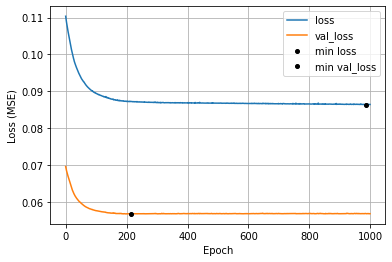

Minimun Loss : 986    0.086391
Name: loss, dtype: float64
---------------------------------------
Minimun Validation Loss : 214    0.05673
Name: val_loss, dtype: float64


In [162]:
plot_loss(history_basemodel)

##Deeper Model

In [163]:
neurons = 1
epoch = 1000
batch_size = 32
reset_random_seeds()

deeper_model = Sequential()
deeper_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
deeper_model.add(Dense(5, activation='relu'))
deeper_model.add(Dense(1))
deeper_model.compile(loss='mean_squared_error', optimizer='adam')

In [164]:
reset_random_seeds()
deeper_model_history = deeper_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.1176 - val_loss: 0.0725
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1161 - val_loss: 0.0718
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1147 - val_loss: 0.0711
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1136 - val_loss: 0.0706
Epoch 5/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1126 - val_loss: 0.0701
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1117 - val_loss: 0.0696
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1109 - val_loss: 0.0692
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1101 - val_loss: 0.0689
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1095 - val_loss: 0.0686
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1089 - val_loss: 0.0682
Epoch 11/1000
9/9 

In [165]:
deeper_history_dataframe = pd.DataFrame(deeper_model_history.history)
deeper_history_dataframe['epoch'] = deeper_model_history.epoch
deeper_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
481,0.081449,0.053947,481
995,0.081154,0.053981,995
756,0.081760,0.053984,756
390,0.081768,0.053988,390
376,0.081861,0.054010,376
...,...,...,...
4,0.112617,0.070087,4
3,0.113595,0.070577,3
2,0.114694,0.071129,2
1,0.116121,0.071758,1


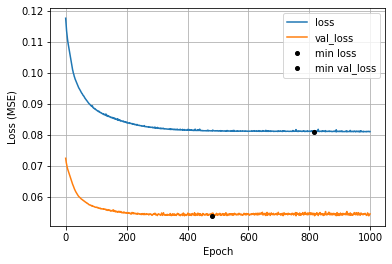

Minimun Loss : 816    0.081044
Name: loss, dtype: float64
---------------------------------------
Minimun Validation Loss : 481    0.053947
Name: val_loss, dtype: float64


In [166]:
plot_loss(deeper_model_history)

##Wilder Model

In [167]:
neurons = 50
epoch = 1000
batch_size = 32
reset_random_seeds()

wider_model = Sequential()
wider_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
wider_model.add(Dense(1))
wider_model.compile(loss='mean_squared_error', optimizer='adam')

In [168]:
reset_random_seeds()
wider_model_history = wider_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1015 - val_loss: 0.0609
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0930 - val_loss: 0.0578
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0881 - val_loss: 0.0561
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0855 - val_loss: 0.0555
Epoch 5/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0839 - val_loss: 0.0552
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0551
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0828 - val_loss: 0.0550
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0826 - val_loss: 0.0545
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0822 - val_loss: 0.0545
Epoch 10/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0819 - val_loss: 0.0545
Epoch 11/1000
9/9 

In [169]:
wider_history_dataframe = pd.DataFrame(wider_model_history.history)
wider_history_dataframe['epoch'] = wider_model_history.epoch
wider_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
62,0.080797,0.054211,62
27,0.081128,0.054218,27
138,0.080539,0.054220,138
117,0.080551,0.054232,117
18,0.081098,0.054239,18
...,...,...,...
853,0.080551,0.056125,853
2,0.088051,0.056125,2
923,0.080361,0.056129,923
1,0.092978,0.057799,1


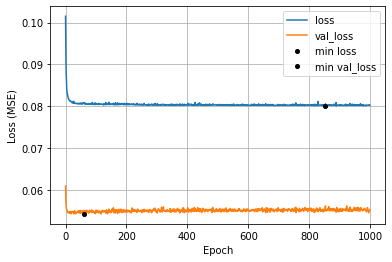

Minimun Loss : 852    0.080045
Name: loss, dtype: float64
---------------------------------------
Minimun Validation Loss : 62    0.054211
Name: val_loss, dtype: float64


In [170]:
ploplot_loss(wider_model_history)t_loss(wider_model_history)

##LSTM

In [171]:
epoch = 1000
batch_size = 32

feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], 1, feature_train.shape[1]))
feature_test_reshaped = np.reshape(feature_test, (feature_test.shape[0], 1, feature_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(40, activation='relu', input_dim=feature_train.shape[1])) # 50 LSTM Block
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [172]:
lstm_model_history = lstm_model.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test_reshaped, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 27ms/step - loss: 0.1114 - val_loss: 0.0693
Epoch 2/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1090 - val_loss: 0.0679
Epoch 3/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1068 - val_loss: 0.0667
Epoch 4/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.1051 - val_loss: 0.0657
Epoch 5/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1034 - val_loss: 0.0649
Epoch 6/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1019 - val_loss: 0.0640
Epoch 7/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1004 - val_loss: 0.0632
Epoch 8/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0990 - val_loss: 0.0624
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0978 - val_loss: 0.0617
Epoch 10/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0965 - val_loss: 0.0610
Epoch 11/1000
9/9 

In [173]:
lstm_history_dataframe = pd.DataFrame(lstm_model_history.history)
lstm_history_dataframe['epoch'] = lstm_model_history.epoch
lstm_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
62,0.080786,0.054583,62
98,0.080551,0.054600,98
301,0.080471,0.054601,301
138,0.080434,0.054610,138
117,0.080461,0.054619,117
...,...,...,...
4,0.103353,0.064878,4
3,0.105082,0.065732,3
2,0.106835,0.066723,2
1,0.108982,0.067895,1


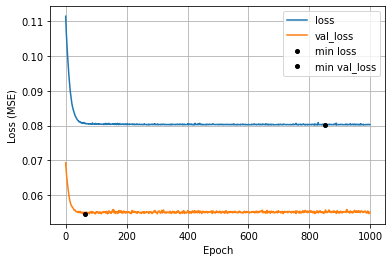

Minimun Loss : 852    0.080168
Name: loss, dtype: float64
---------------------------------------
Minimun Validation Loss : 62    0.054583
Name: val_loss, dtype: float64


In [174]:
plot_loss(lstm_model_history)

#Kesimpulan :

### **Dari dataset Birth, saya melakukan pengujian dengan 4 model yaitu baseline model, deeper model, wider model dan LSTM. Dari data Birth, Deeper Model lah yang terbaik untuk menghasilkan MSE terkecil yaitu dengan nilai 0.053 di bandingkan dengan menggunakan model lain.**

### **Namun pada dataset lain hasil yang didapatkan jg berbeda.**